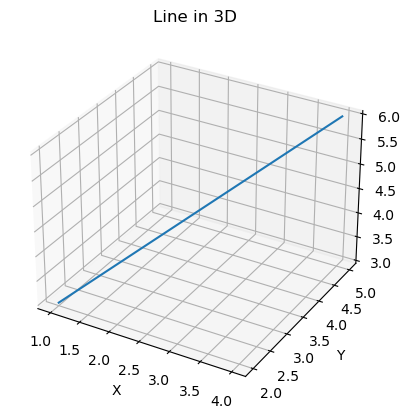

In [1]:
import matplotlib.pyplot as plt

# Define the coordinates of point A and point B
x_A, y_A, z_A = 1, 2, 3
x_B, y_B, z_B = 4, 5, 6

# Set up the figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the line from point A to point B
ax.plot([x_A, x_B], [y_A, y_B], [z_A, z_B])

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Line in 3D')

# Display the plot
plt.show()

In [2]:
import torch

batch_size= 32
num_joints = 26
emb_dim = 64
joint_dim = 9

W_enc = torch.randn(num_joints, emb_dim, joint_dim)
b_enc = torch.randn(num_joints, emb_dim)
W_dec = torch.randn(num_joints, joint_dim, emb_dim)
b_dec = torch.randn(num_joints, joint_dim)

def encode_joints(x: torch.Tensor) -> torch.Tensor:
    """
        Initial joint embedding.
    """
    x = torch.einsum('njk,bsnk->bsnj', W_enc, x)
    x = torch.einsum('nj,bsnj->bsnj', b_enc, x)
    return x

def decode_joints(self, x: torch.Tensor) -> torch.Tensor:
    """
        Final joint decoding into the original representation.
    """
    x = torch.einsum('njk,bsnk->bsnj', self.W_dec, x)
    x = torch.einsum('nj,bsnk->bsnk', self.b_dec, x)
    return x

In [4]:
dim_a = 10
dim_b = 20

x = torch.randn(dim_a, dim_b)
y = torch.randn(dim_a, dim_b)

zg = x + y
yt = torch.einsum('ab,ab', x, y)

torch.allclose(x, y, atol=1e-03)

False

In [1]:
import torch

def cross_product_einsum(u, v):
    return torch.einsum("ijk,jk->ik", [torch.tensor([[0, 0, 0], [0, 0, 1], [0, -1, 0]]), v])

# Example input vectors
u = torch.tensor([1.0, 0.0, 0.0])
v = torch.tensor([0.0, 1.0, 0.0])

result = cross_product_einsum(u, v)
print("Cross Product:", result)

RuntimeError: einsum(): the number of subscripts in the equation (3) does not match the number of dimensions (2) for operand 0 and no ellipsis was given

In [1]:
import torch

from src.data_utils import getDataset
from src.utils import load_config

config = load_config('baseline_config')

dataset = getDataset(
                config['dataset'],
                joint_representation = config['joint_representation']['type'],
                skeleton_model = config['skeleton']['type'],
                is_train=True,
                debug=True
            )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ldenninger (visionlabss23). Use `wandb login --relogin` to force relogin


Loading Human3.6M data...


100%|██████████| 30/30 [00:06<00:00,  4.87it/s]


In [2]:
from typing import Optional, List, Union, Literal
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec 

from src.data_utils import h36m_forward_kinematics, H36M_REDUCED_SKELETON_STRUCTURE, H36M_REVERSED_REDUCED_ANGLE_INDICES
from src.visualization import JOINT_COLOR_MAP

def draw_sequence_comp_plot(sequences: Union[List[torch.Tensor], torch.Tensor],
                             timesteps: List[int],
                              skeleton_model: Optional[Literal['s26']] = 's26',
                               rot_representation: Literal['axis', 'mat', 'quat', '6d'] = 'mat',
                                visualize_joints: Optional[bool] = False):

    def create_pose_visualization(ax: plt.axis, frame: torch.Tensor):
        ax.cla()
        ax.set_xlim3d([-10, 10])  # Set the x-axis limits
        ax.set_ylim3d([-10, 10])  # Set the y-axis limits
        ax.set_zlim3d([-10, 10])  # Set the z-axis limits
        ax.set_xlabel("X")
        ax.set_ylabel("Z")
        ax.set_zlabel("Y")
        ax.axis('off')
        for id, (cur_frame, par_frame) in skeleton_structure.items():
            if visualize_joints:
                ax.scatter(
                    frame[id][0] / 100.0,
                    frame[id][2] / 100.0,
                    frame[id][1] / 100.0,
                    label=cur_frame,
                    c=JOINT_COLOR_MAP[cur_frame],
                )
            if id==0:
                continue
            start_pos = frame[id].numpy() / 100.0
            end_pos = frame[name_to_ind[par_frame]].numpy() / 100.0
            ax.plot(
                [start_pos[0], end_pos[0]],
                [start_pos[2], end_pos[2]],
                [start_pos[1], end_pos[1]],
                c="g",
            )
        main_grid.tight_layout(fig)
        return ax

    num_sequences = len(sequences)
    num_timesteps = len(timesteps)

    if skeleton_model =='s26':
        forward_kinematics = h36m_forward_kinematics
        skeleton_structure = H36M_REDUCED_SKELETON_STRUCTURE
        name_to_ind = H36M_REVERSED_REDUCED_ANGLE_INDICES
    else:
        raise ValueError(f'Skeleton model {skeleton_model} is not supported')

    fig = plt.figure(figsize=(30,15))
    main_grid = GridSpec(num_sequences*2, num_timesteps, figure=fig)

    for row in range(num_sequences):
        sequence = sequences[row]
        positions, abs_rotations = forward_kinematics(sequence, rot_representation)
        for col in range(num_timesteps):
            frame = positions[col]
            ax = fig.add_subplot(main_grid[row*2:row*2+1, col], projection='3d')
            ax = create_pose_visualization(ax, frame)
            if row == 0:
                ax.set_title(f'Timestep: {timesteps[col]}')
    return fig







/tmp/ipykernel_21505/282054132.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


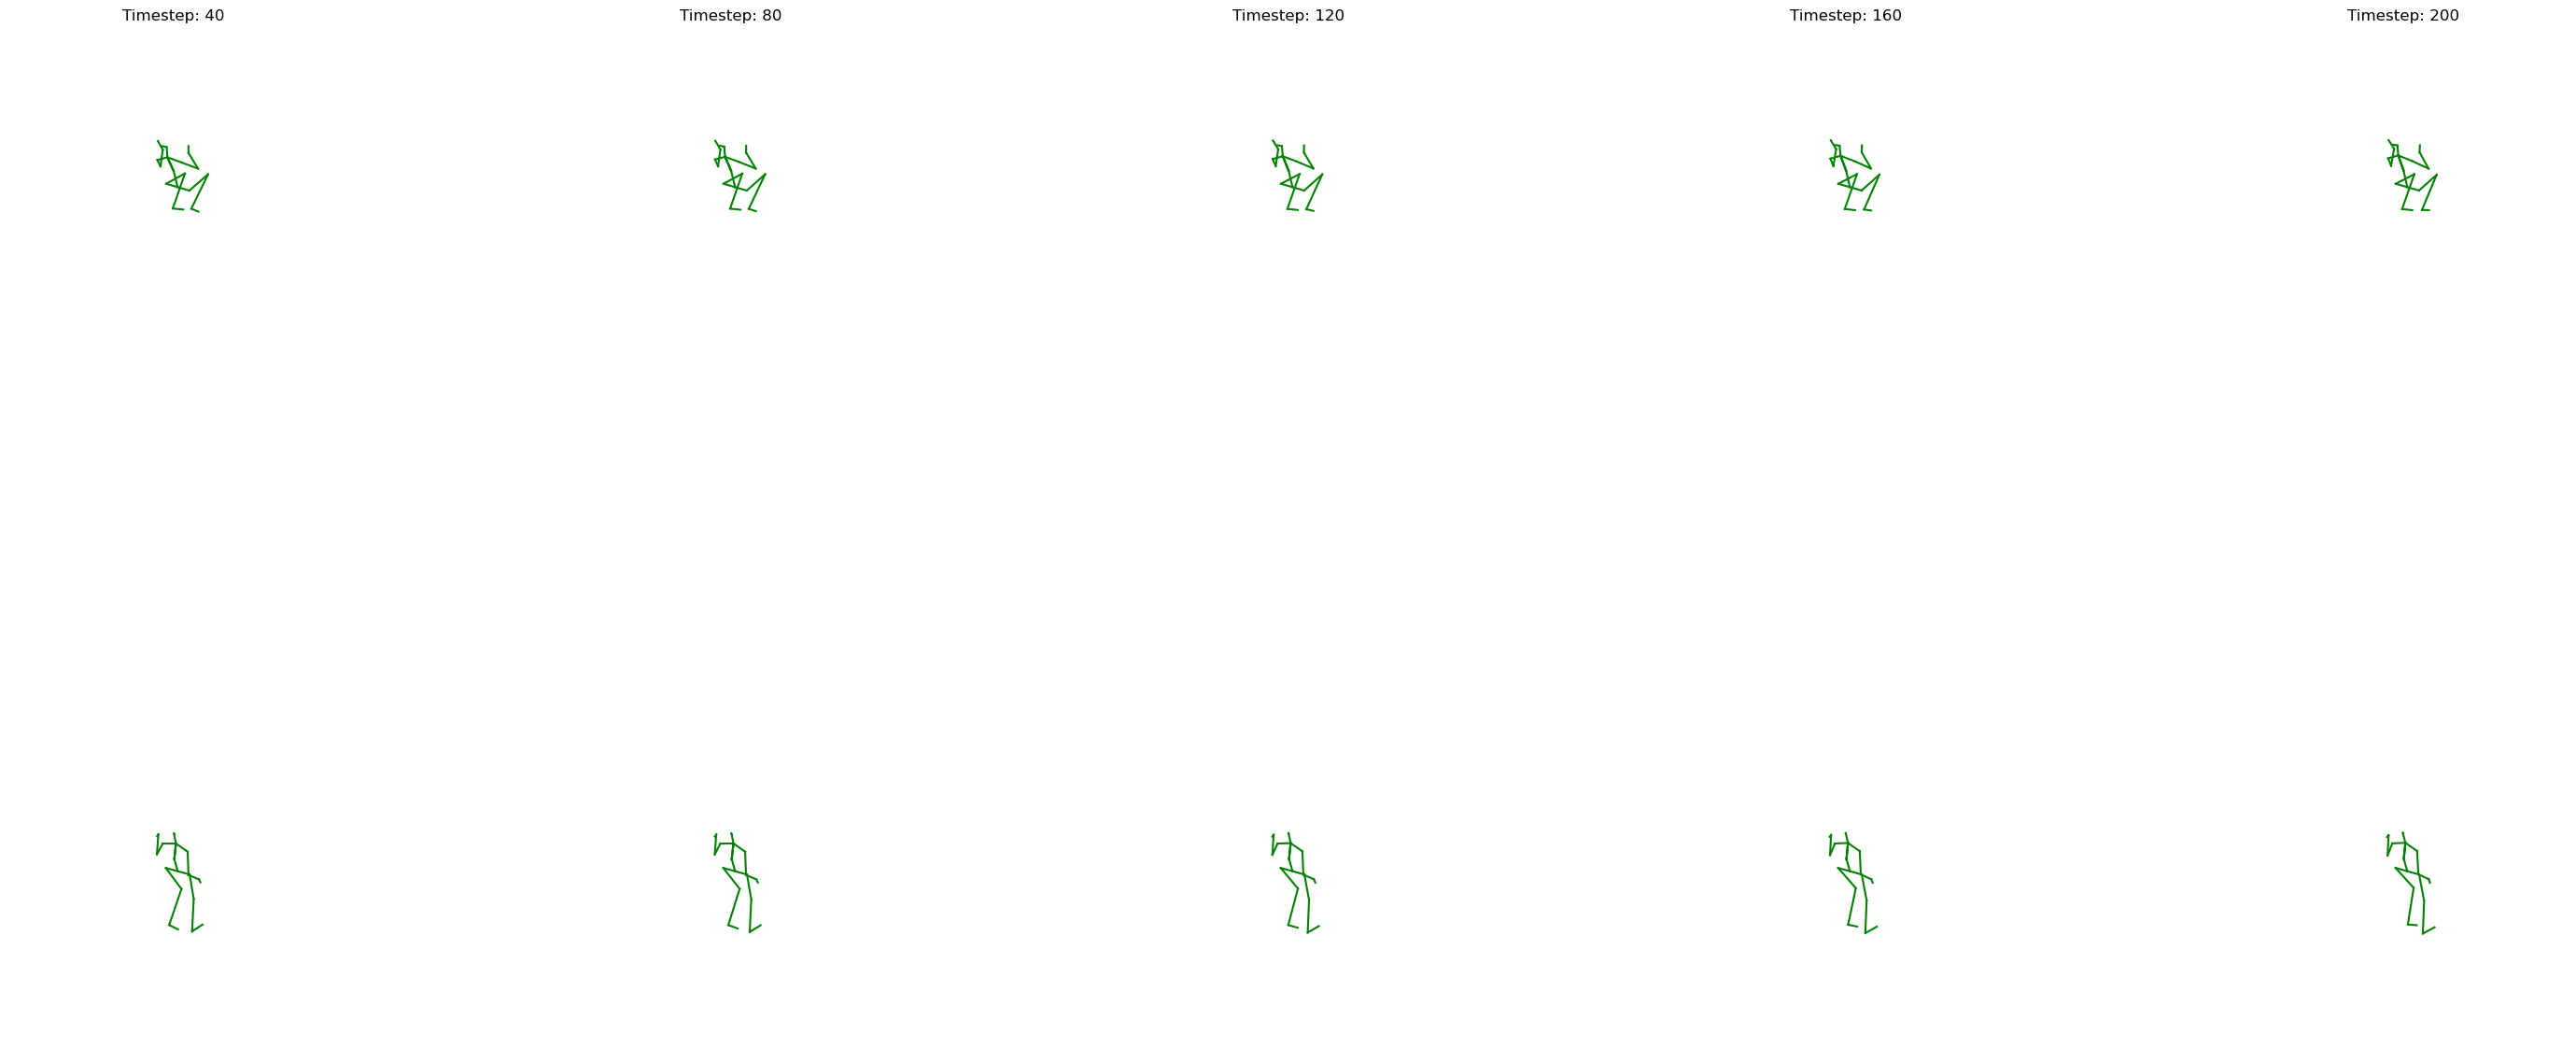

In [5]:
from torch.utils.data import DataLoader
import numpy as np

data_loader = DataLoader(dataset, batch_size=2, shuffle=True)
timesteps = np.arange(1,6)*40

for i, data in enumerate(data_loader):
    if i==1:
        break
    fig = draw_sequence_comp_plot(data, timesteps)
    fig.show()